In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
from scipy.spatial.distance import cdist
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import Isomap, MDS
from sklearn.cluster import AffinityPropagation

In [2]:
adata = sc.read_h5ad('data/adata_ge1_HQstrict_guides.h5ad')
adata

AnnData object with n_obs × n_vars = 2727 × 38607
    obs: 'library_name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'GEX_UMI_count', 'n_genes', 'MT_count', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_guides_ge_0.9', 'called_guides'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'ribo', 'hb'
    uns: 'cleanser_guides', 'guide_names'
    obsm: 'cleanser_posteriors', 'guide_calls_bin'

In [3]:
glist = adata.obs['called_guides'].tolist()

In [4]:
guide_list = []
for entry in glist:
    arr = entry.split(',')
    for a in arr:
        guide_list.append(a)


len(guide_list)
guide_set = set(guide_list)
    

In [5]:
guide_set

{'BAG3_g1',
 'BAG3_g2',
 'DES_g1',
 'DES_g2',
 'FLNC_g1',
 'LMNA_g1',
 'MYH7_g1',
 'NKX2-5_g1',
 'NKX2-5_g2',
 'SCN5A_g1',
 'SCN5A_g2',
 'TBX20_g1',
 'TBX20_g2',
 'TDA_MYH6',
 'TDA_MYH7',
 'TNNC1_g1',
 'TNNC1_g2',
 'TNNT2_g1',
 'TNNT2_g2',
 'TPM1_g1',
 'TPM1_g2',
 'TTN_g1',
 'TTN_g2',
 'nt_g1',
 'nt_g2',
 'nt_g3',
 'st_g1',
 'st_g2'}

## PCA

/opt/apps/rhel9/Anaconda3-2024.02/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


PCA Complete.
PCA Coordinates shape: (2727, 50)


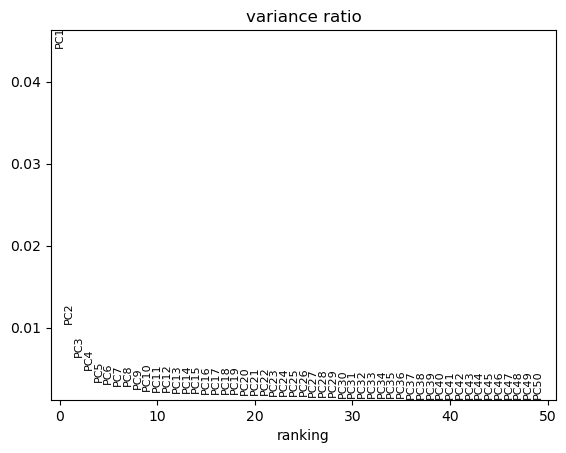

In [6]:

if hasattr(adata.X, 'data'):
    adata.X.data = np.nan_to_num(adata.X.data, posinf=100, neginf=0)
else:
    adata.X = np.nan_to_num(adata.X, posinf=100, neginf=0)

sc.pp.normalize_total(adata, target_sum=1e4)

# 4. Scale (Center mean to 0, variance to 1)
sc.pp.scale(adata, max_value=10)

# --- RUN PCA (On All Genes) ---
sc.tl.pca(adata, n_comps=50, svd_solver='arpack')

print("PCA Complete.")
print(f"PCA Coordinates shape: {adata.obsm['X_pca'].shape}")

sc.pl.pca_variance_ratio(adata, n_pcs=50)

In [7]:
##Which genes in which component

pc_index = 0 

loadings = adata.varm['PCs'][:, pc_index]

gene_scores = pd.DataFrame({
    'Gene': adata.var_names,
    'Loading_Score': loadings
})

gene_scores['Magnitude'] = gene_scores['Loading_Score'].abs()
sorted_genes = gene_scores.sort_values('Magnitude', ascending=False)

sorted_genes.head(20)

,Gene,Loading_Score,Magnitude
19165,CTNNA3,0.036405,0.036405
3424,RYR2,0.036336,0.036336
32176,FHOD3,0.035439,0.035439
4093,SLC8A1,0.034319,0.034319
9687,PALLD,0.034108,0.034108
19732,RBM20,0.033529,0.033529
5836,ERBB4,0.033495,0.033495
22221,CACNA1C,0.033461,0.033461
8614,PCDH7,0.033421,0.033421
37444,DMD,0.033293,0.033293


In [8]:
cell_scores = adata.obsm['X_pca'][:, 0]
score_abs = adata.obsm['X_pca'][:,0]

cell_scores.sort()
print(cell_scores[:20])

# Check the range (Min and Max)
#print(f"\nLowest Cell Score: {cell_scores.average()}")
#print(f"Highest Cell Score: {cell_scores.average()}")

[-40.51147  -36.98468  -36.301785 -36.150944 -36.136963 -35.690273
 -35.36944  -35.19706  -35.03971  -34.807465 -34.456123 -33.608597
 -33.543423 -33.48761  -33.137554 -32.81241  -32.772057 -32.68723
 -32.631714 -32.608143]


In [9]:
adata.obs

,library_name,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,GEX_UMI_count,n_genes,...,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,n_guides_ge_0.9,called_guides
AAACCAGCAACCTGCA-1,1,6911,8.841014,43924.0,10.690239,5828.0,8.670601,13.268373,43924,6911,...,50.794554,63.088517,5221.0,8.560636,11.886440,26.0,3.295837,0.059193,1,TTN_g2
AAACCGTGTGCGAGAG-1,1,8687,9.069698,64083.0,11.067950,4450.0,8.400884,6.944119,64083,8687,...,45.386452,56.846590,6617.0,8.797548,10.325672,1.0,0.693147,0.001560,2,"TNNC1_g1,SCN5A_g2"
AAACCTGTCATGGGCT-1,1,8310,9.025335,53561.0,10.888596,7052.0,8.861208,13.166296,53561,8310,...,42.142604,53.296242,2311.0,7.745868,4.314706,7.0,2.079442,0.013069,5,"TTN_g1,DES_g2,TNNC1_g1,TPM1_g2,TBX20_g1"
AAACCTGTCGTTCATC-1,1,5299,8.575462,28878.0,10.270870,2635.0,7.877018,9.124594,28878,5299,...,52.662927,65.188032,4837.0,8.484257,16.749775,2.0,1.098612,0.006926,1,TPM1_g2
AAACGATCAAGTGCCC-1,1,7286,8.893847,57162.0,10.953662,6156.0,8.725345,10.769393,57162,7286,...,52.382702,64.425667,8492.0,9.046998,14.856023,2.0,1.098612,0.003499,3,"TNNT2_g2,FLNC_g1,nt_g1"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTTGGCGTCGGACTAC-1,1,4750,8.466110,18272.0,9.813180,1800.0,7.496098,9.851138,18272,4750,...,48.516856,61.274081,1687.0,7.431300,9.232706,1.0,0.693147,0.005473,2,"TTN_g2,TNNT2_g1"
GTTGGGCGTCTAACGG-1,1,7206,8.882808,50387.0,10.827508,6957.0,8.847648,13.807133,50387,7206,...,51.072697,62.305753,4173.0,8.336630,8.281898,1.0,0.693147,0.001985,3,"TNNT2_g1,SCN5A_g1,SCN5A_g2"
GTTGGTCAGCAAGAGT-1,1,575,6.356108,1059.0,6.966024,301.0,5.710427,28.423040,1059,575,...,64.589235,92.917847,131.0,4.882802,12.370160,0.0,0.000000,0.000000,3,"TNNT2_g1,FLNC_g1,TBX20_g2"
GTTGGTTCAACTCCCT-1,1,6888,8.837681,39774.0,10.590994,4061.0,8.309431,10.210188,39774,6888,...,47.163976,59.347815,3908.0,8.271037,9.825514,1.0,0.693147,0.002514,1,MYH7_g1


## ENERGY DISTANCE

In [12]:
def calculate_energy_distance(x_pca, y_pca):
    """
    Calculates the Energy Distance between two groups of cells.
    
    Args:
        x_pca (np.array): PCA coordinates for Group X (Perturbed)
                          Shape: (n_cells_x, 50)
        y_pca (np.array): PCA coordinates for Group Y (Control)
                          Shape: (n_cells_y, 50)
    
    Returns:
        float: The Energy Distance score (>= 0)
    """
    # 1. Calculate Term A: Average distance between X and Y
    d_xy = cdist(x_pca, y_pca, metric='euclidean')
    A = np.mean(d_xy)
    
    # 2. Calculate Term B: Average distance within X
    d_xx = cdist(x_pca, x_pca, metric='euclidean')
    B = np.mean(d_xx)
    
    # 3. Calculate Term C: Average distance within Y
    d_yy = cdist(y_pca, y_pca, metric='euclidean')
    C = np.mean(d_yy)
    
    # 4. Final Formula: E = 2A - B - C
    e_dist = (2 * A) - B - C
    
    return max(0, e_dist) #0 to avoid floating point errors



import numpy as np

def run_permutation_test(X, Y, n_perms=1000):
    """
    Calculates the P-value for Energy Distance using a permutation test.
    
    Args:
        X (np.array): Perturbed cells (n_x, 50)
        Y (np.array): Control cells (n_y, 50)
        n_perms (int): Number of shuffles (Standard is 1000 or 10,000)
        
    Returns:
        p_value (float): The probability that the result is random.
        actual_dist (float): The raw Energy Distance score.
    """
    actual_dist = calculate_energy_distance(X, Y)
    
    if actual_dist < 0.1: 
        return 1.0, actual_dist

    pooled = np.vstack([X, Y])
    n_x = X.shape[0]
    total_cells = pooled.shape[0]
    
    fake_scores = []
    
    for _ in range(n_perms):
        shuffled_indices = np.random.permutation(total_cells)
        
        fake_X = pooled[shuffled_indices[:n_x]]
        fake_Y = pooled[shuffled_indices[n_x:]]
        
        score = calculate_energy_distance(fake_X, fake_Y)
        fake_scores.append(score)
    
    fake_scores = np.array(fake_scores)
    
    n_better = np.sum(fake_scores >= actual_dist)
    
    p_value = (n_better + 1) / (n_perms + 1)
    
    return p_value, actual_dist

In [13]:
def filter_pure_guides(cell_label, allowed_prefixes):
    if pd.isna(cell_label):
        return False

    guides = str(cell_label).replace('|', ',').split(',')
    
    return all(g.strip().startswith(allowed_prefixes) for g in guides)


# nt
pure_nt_mask = adata.obs['called_guides'].apply(
    lambda x: filter_pure_guides(x, allowed_prefixes=('nt_'))
)

# st
pure_st_mask = adata.obs['called_guides'].apply(
    lambda x: filter_pure_guides(x, allowed_prefixes=('st_'))
)

#mega control
pure_control_mask = adata.obs['called_guides'].apply(
    lambda x: filter_pure_guides(x, allowed_prefixes=('nt_', 'st_'))
)


nt_cells = adata[pure_nt_mask].obsm['X_pca']
st_cells = adata[pure_st_mask].obsm['X_pca']
nt_st_cells = adata[pure_control_mask].obsm['X_pca']

print(f"Original NT Count: {pure_nt_mask.sum()}")
print(f"Clean NT Count:    {nt_cells.sum()}")
print(f"Dropped {pure_nt_mask.sum() - nt_cells.sum()} contaminated cells.")

Original NT Count: 224
Clean NT Count:    201.742431640625
Dropped 22.257568359375 contaminated cells.


In [14]:
def subsample(data, n=2000):
    if len(data) > n:
        return data[np.random.choice(len(data), n, replace=False)]
    return data

num_cells = max(len(nt_cells),len(st_cells))
#nt_sample = subsample(st_cells,n = num_cells)
#st_sample = subsample(nt_st_cells,n = num_cells)
nt_sample = subsample(st_cells)
st_sample = subsample(nt_st_cells)

print(f"Comparing {len(nt_sample)} NT cells vs {len(st_sample)} ST cells...")

# 4. Run the Calculation
# (Using the function you defined earlier)
control_dist = calculate_energy_distance(nt_sample, st_sample)

print(f"Energy Distance (ST vs NT): {control_dist:.4f}")
len(nt_st_cells)

Comparing 89 NT cells vs 630 ST cells...
Energy Distance (ST vs NT): 0.7027


630

In [ ]:
adata

In [15]:
target_set = {
    'BAG3_g1','BAG3_g2','BAG',
    'DES_g1','DES_g2','DES',
    'FLNC_g1',
    'LMNA_g1',
    'NKX2-5_g1','NKX2-5_g2','NKX2',
    'SCN5A_g1','SCN5A_g2','SCN5A',
    'TBX20_g1','TBX20_g2','TBX20',
    'TDA_MYH6','TDA_MYH7','TDA',
    'TNNC1_g1','TNNC1_g2','TNNC1',
    'TNNT2_g1','TNNT2_g2','TNNT2',
    'TPM1_g1','TPM1_g2','TPM1',
    'TTN_g1','TTN_g2','TTN',
}   

In [17]:

results = []
control_cells = nt_st_cells

for i,guide in enumerate(target_set):
    guide_mask = adata.obs['called_guides'].apply(
        lambda x: filter_pure_guides(x, allowed_prefixes=(guide))
    )
    guide_cells = adata[guide_mask].obsm['X_pca']
    
    perm_p, e_dis = run_permutation_test(guide_cells, control_cells, n_perms=1000)
    
    lim = max(len(guide_cells), len(control_cells))
    lim_guide_cells = subsample(guide_cells, lim)
    lim_control_cells = subsample(control_cells,lim) 
    
    
    lim_perm_p, lim_e_dis = run_permutation_test(lim_guide_cells, lim_control_cells, n_perms=1000)
    
    results.append({
        "guide": guide,
        "perm_p": perm_p,
        "e_dist": e_dis,
        "lim_perm_p": lim_perm_p,
        "lim_e_dist": lim_e_dis,
        "significant": perm_p < 0.05
    })
    
    print(f"run {i} guide {guide} complete")

run 0 guide BAG complete


KeyboardInterrupt: 

In [ ]:
resultsdf = pd.DataFrame(results)
resultsdf.to_csv('guide_control_distance.csv')

## Pairwise Distance Matrix

In [19]:
sig_genes = resultsdf[resultsdf['significant']]['guide'].tolist()
len(sig_genes)

NameError: name 'resultsdf' is not defined

In [21]:
def create_dist_matrix(genes):
    n_genes = len(genes)
    dist_matrix = pd.DataFrame(index=genes, columns=genes, dtype=float)
    
    print(f"Calculating {n_genes * n_genes} pairwise distances...")
    
    for i, gene_A in enumerate(genes):
        A_guide_mask = adata.obs['called_guides'].apply(
            lambda x: filter_pure_guides(x, allowed_prefixes=(gene_A))
        )
        X_A = adata[A_guide_mask].obsm['X_pca']
        
        for j, gene_B in enumerate(genes):
            if i > j:
                dist_matrix.iloc[i, j] = dist_matrix.iloc[j, i]
                continue
            
            if i == j:
                dist_matrix.iloc[i, j] = 0.0
                continue
            B_guide_mask = adata.obs['called_guides'].apply(
            lambda x: filter_pure_guides(x, allowed_prefixes=(gene_B))
            )
            X_B = adata[B_guide_mask].obsm['X_pca']

            
            d = calculate_energy_distance(X_A, X_B)
            dist_matrix.iloc[i, j] = d

    return dist_matrix


In [26]:
no_control_set = {
    'BAG3_g1','BAG3_g2',
    'DES_g1','DES_g2',
    'FLNC_g1',
    'LMNA_g1',
    'NKX2-5_g1','NKX2-5_g2',
    'SCN5A_g1','SCN5A_g2',
    'TBX20_g1','TBX20_g2',
    'TDA_MYH6','TDA_MYH7',
    'TNNC1_g1','TNNC1_g2',
    'TNNT2_g1','TNNT2_g2',
    'TPM1_g1','TPM1_g2',
    'TTN_g1','TTN_g2',
}   

only_gene_set = {
    'BAG',
    'DES',
    'FLNC',
    'LMNA',
    'NKX2',
    'SCN5A',
    'TBX20',
    'TDA',
    'TNNC1',
    'TNNT2',
    'TPM1',
    'TTN',
}   

Calculating 484 pairwise distances...
Calculating 144 pairwise distances...


/hpc/home/zy231/.local/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/hpc/home/zy231/.local/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


<Figure size 1000x1000 with 0 Axes>

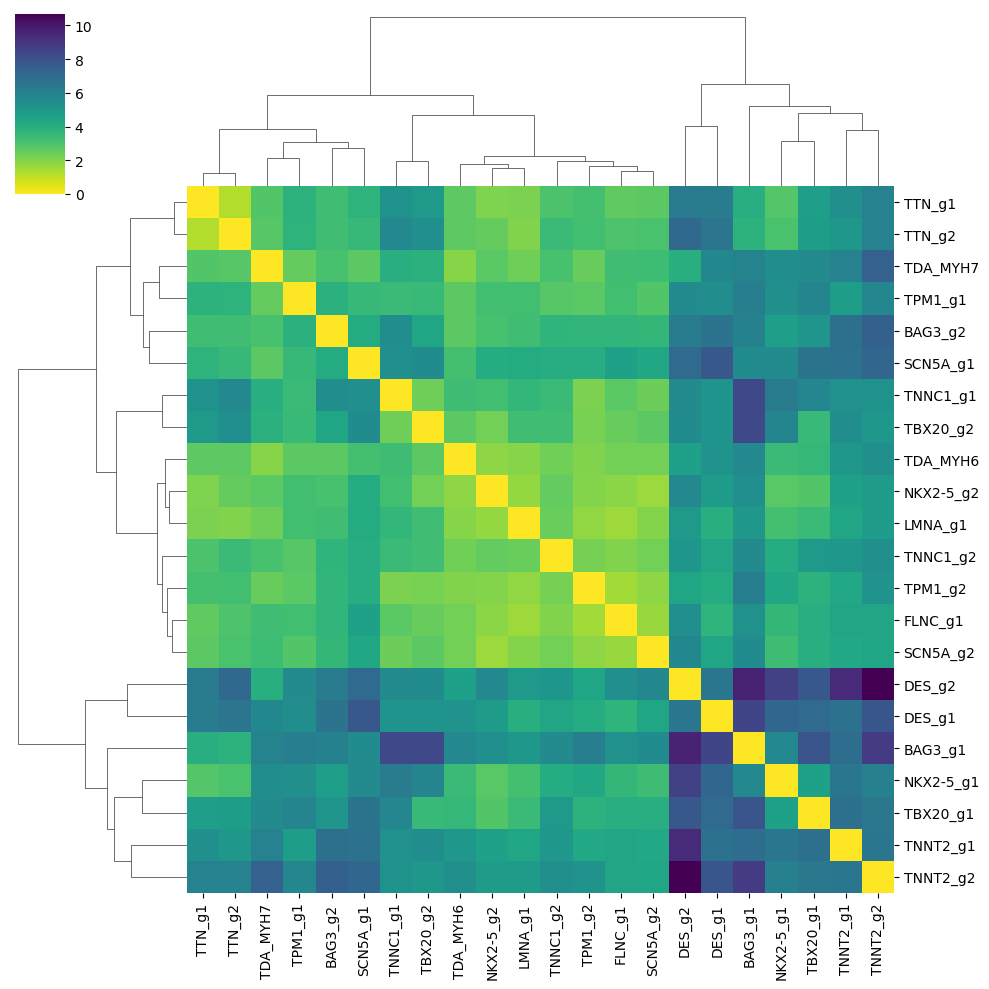

In [32]:
#sig_genes = resultsdf[resultsdf['significant']]['guide'].tolist()
#dist_matrix = create_dist_matrix(sig_genes)

#all_genes = resultsdf['guide'].tolist()
#dist_matrix = create_dist_matrix(all_genes)

#guide_list = list(guide_set)

no_control_list = list(no_control_set)

#only_gene_list = list(only_gene_set)

dist_matrix = create_dist_matrix(guide_list)
#no_control_matrix = create_dist_matrix(no_control_list)
#only_gene_matrix = create_dist_matrix(only_gene_list)
plt.figure(figsize=(10, 10))
sns.clustermap(dist_matrix, cmap="viridis_r", method='ward')
plt.savefig('no_contorl_matrix.jpg')

## Embedding and clustering

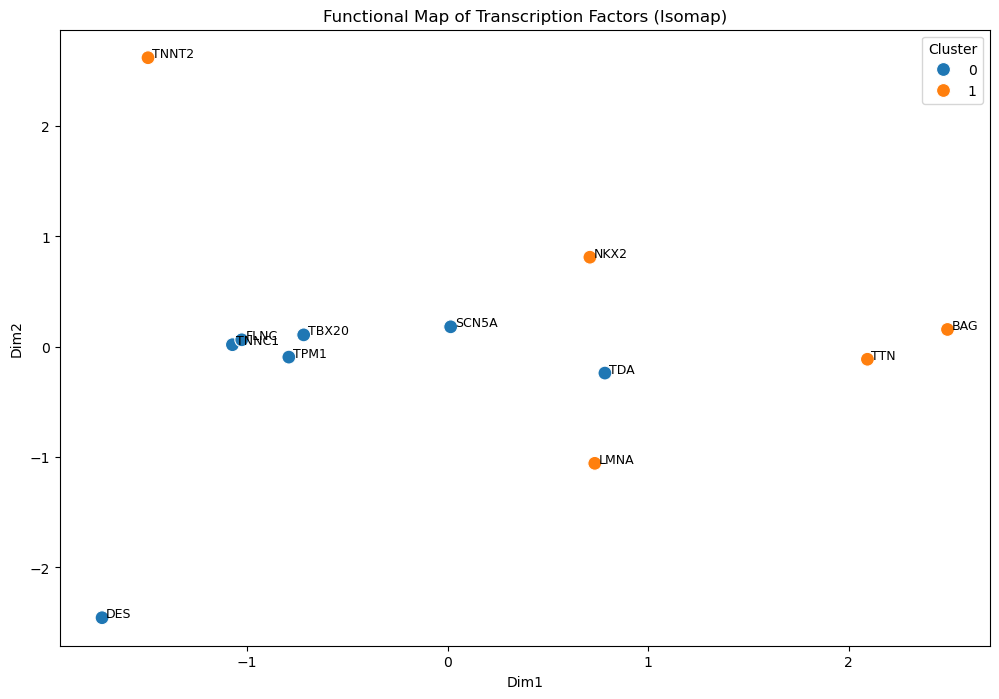

In [45]:
embedding = Isomap(n_components=2, metric='precomputed')
coords = embedding.fit_transform(only_gene_matrix.values)

# 2. Run Clustering (Affinity Propagation)
af = AffinityPropagation(damping=0.9, random_state=42).fit(only_gene_matrix.values)
cluster_labels = af.labels_

# 3. Create a DataFrame for Plotting
map_df = pd.DataFrame({
    'Gene': only_gene_matrix.index,
    'Dim1': coords[:, 0],
    'Dim2': coords[:, 1],
    'Cluster': cluster_labels
})

# 4. Plot the Map (Fig 1f)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=map_df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', s=100)

# Add labels to points
for i in range(map_df.shape[0]):
    plt.text(map_df.Dim1[i]+0.02, map_df.Dim2[i], map_df.Gene[i], fontsize=9)

plt.title("Functional Map of Transcription Factors (Isomap)")
plt.savefig('only_gene_isomap_cluster.jpg')
plt.show()

/hpc/home/zy231/.local/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


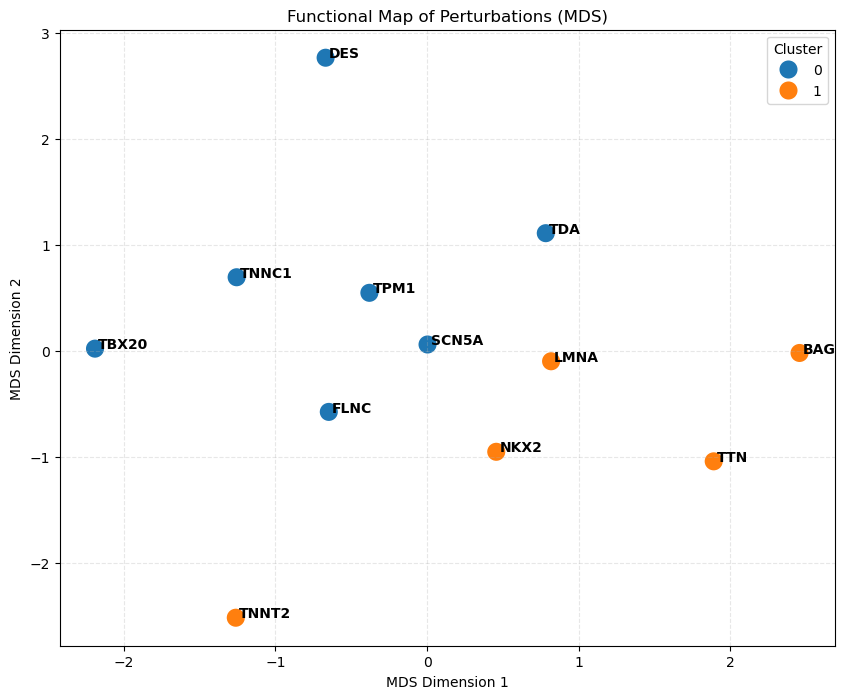

In [42]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')

coords = mds.fit_transform(only_gene_matrix.values)

af = AffinityPropagation(damping=0.9, random_state=42).fit(only_gene_matrix.values)
cluster_labels = af.labels_

map_df = pd.DataFrame({
    'Gene': only_gene_matrix.index,
    'Dim1': coords[:, 0],
    'Dim2': coords[:, 1],
    'Cluster': cluster_labels 
})

plt.figure(figsize=(10, 8))
sns.scatterplot(data=map_df, x='Dim1', y='Dim2', hue='Cluster', palette='tab10', s=200)

for i in range(map_df.shape[0]):
    plt.text(map_df.Dim1[i]+0.02, map_df.Dim2[i], map_df.Gene[i], fontsize=10, weight='bold')

plt.title("Functional Map of Perturbations (MDS)")
plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.savefig("only_gene_MDS_cluster.jpg")
plt.show()

## Expression Distribution

In [ ]:
mean_expr = {}
for gene in universe_genes:
    if gene in adata.var_names:
        mean_val = np.mean(adata[:, gene].X)
        mean_expr[gene] = mean_val

expr_df = pd.DataFrame.from_dict(mean_expr, orient='index', columns=['Mean_Expression'])
expr_df['Is_Significant'] = expr_df.index.isin(sig_genes)

plt.figure(figsize=(8, 6))
sns.histplot(data=expr_df, x='Mean_Expression', hue='Is_Significant', 
             log_scale=True, element="step", stat="density", common_norm=False)
plt.title("Expression Levels: Hits vs Non-Hits")
plt.show()

In [ ]:
targets

In [ ]:
df_sensitivity

In [ ]:
# 2. Plot the Scatter
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_sensitivity, 
    x='Mean_Expression', 
    y='Energy_Distance', 
    hue='Type', 
    style='Type',
    s=200, 
    palette='deep'
)

# 3. Label every point (Since you only have 14, this is readable!)
for i in range(df_sensitivity.shape[0]):
    plt.text(
        df_sensitivity.Mean_Expression[i]+0.1, 
        df_sensitivity.Energy_Distance[i], 
        df_sensitivity.Gene[i], 
        fontsize=11, 
        weight='bold'
    )

plt.title("Screen Sensitivity: Phenotype Strength vs. Gene Abundance")
plt.xlabel("Log Mean Expression (Control Cells)")
plt.ylabel("Energy Distance (Phenotype Strength)")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

## PLOTS

In [ ]:
sc.pl.pca_loadings(adata, components=[1, 2, 3])

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)